In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

In [3]:
from run import global_seeds, data_set_index, algorithm_index

In [4]:
data_path = "results/preprocessed/"
table_path = "results/tables/"
plot_path = "results/plots/"

## 0 Preprocessing

### 0.1 Load and Build Plotting Data

In [5]:
datasets = list(data_set_index.index)
bin_data = data_set_index[data_set_index["classes"] == 2].index
mc_data = data_set_index[data_set_index["classes"] > 2].index

### 0.1.1 Create big dataframes containing all experiments for binary and multiclass data

In [6]:
bin_df = pd.read_csv(data_path + "adult_stats_metrics.csv")

In [7]:
ae_cols = [col for col in list(bin_df) if "_AE" in col]
nkld_cols = [col for col in list(bin_df) if "NKLD" in col]
key_cols = list(bin_df)[:4] + ["dataset","Drift_MAE"]

fin_cols = key_cols + ae_cols + nkld_cols

In [8]:
bin_df["dataset"] = "adult"
bin_df = bin_df[fin_cols]
for ds in bin_data[1:]:
    df = pd.read_csv(data_path + ds + "_stats_metrics.csv")
    df["dataset"] = ds
    bin_df = pd.concat([bin_df,df[fin_cols]])

In [9]:
bin_df.head()

,Seed,TT_split,D_train,D_test,dataset,Drift_MAE,AC_AE,PAC_AE,TSX_AE,TS50_AE,...,ED_NKLD,EM_NKLD,CDE_NKLD,CC_NKLD,PCC_NKLD,SVM-K_NKLD,SVM-Q_NKLD,PWK_NKLD,QF_NKLD,QF-AC_NKLD
0,42,10/90,10/90,10/90,adult,0.0,0.013090,0.021576,0.026877,0.008800,...,0.000216,0.000797,0.779335,0.030929,0.000083,0.003788,0.028162,0.147148,0.003842,3.122052e-07
1,42,10/90,10/90,20/80,adult,0.1,0.034365,0.020291,0.000592,0.037992,...,0.000230,0.000122,0.067706,0.074266,0.013359,0.015981,0.064176,0.085198,0.039331,1.944117e-03
2,42,10/90,10/90,30/70,adult,0.2,0.066101,0.027302,0.004811,0.017683,...,0.000191,0.000030,0.052212,0.126141,0.041072,0.052577,0.116014,0.052995,0.091930,6.436209e-03
3,42,10/90,10/90,40/60,adult,0.3,0.025580,0.020836,0.000970,0.007269,...,0.000022,0.000008,0.030111,0.175793,0.074216,0.094570,0.155294,0.024810,0.164180,7.604349e-03
4,42,10/90,10/90,50/50,adult,0.4,0.053973,0.055297,0.023683,0.031476,...,0.000253,0.000110,0.023838,0.232039,0.117305,0.131835,0.216446,0.006353,0.202066,1.650108e-02


In [10]:
mc_df = pd.read_csv(data_path + "bike_stats_metrics.csv")

In [11]:
ae_mc_cols = [col for col in list(mc_df) if "_AE" in col]
nkld_mc_cols = [col for col in list(mc_df) if "NKLD" in col]
key_cols = list(mc_df)[:4] + ["dataset","Drift_MAE"]
fin_mc_cols = key_cols + ae_mc_cols + nkld_mc_cols

In [12]:
mc_df["dataset"] = "bike"
mc_df = mc_df[fin_mc_cols]
for ds in mc_data[1:]:
    df = pd.read_csv(data_path + ds + "_stats_metrics.csv")
    df["dataset"] = ds
    mc_df = pd.concat([mc_df,df[fin_mc_cols]])

In [13]:
mc_df.head()

,Seed,TT_split,D_train,D_test,dataset,Drift_MAE,AC_AE,PAC_AE,TSX_AE,TS50_AE,...,readme_NKLD,HDx_NKLD,HDy_NKLD,FM_NKLD,ED_NKLD,EM_NKLD,CC_NKLD,PCC_NKLD,PWK_NKLD,QF_NKLD
0,42,10/90,50/30/10/10,65/25/05/05,bike,0.075,0.599920,0.645781,0.699839,0.599920,...,0.009398,0.393722,0.003933,0.001780,0.008791,0.001780,0.021826,0.010500,0.139385,0.019366
1,42,10/90,50/30/10/10,20/25/30/25,bike,0.175,0.604448,0.301703,0.215830,0.187496,...,0.009512,0.163529,0.007960,0.005416,0.011503,0.005416,0.220327,0.055120,0.000832,0.123843
2,42,10/90,50/30/10/10,45/15/20/20,bike,0.100,0.699984,0.237999,0.155797,0.305748,...,0.021973,0.928026,0.008923,0.004753,0.026292,0.004753,0.154760,0.046172,0.043882,0.114246
3,42,10/90,50/30/10/10,20/0/0/80,bike,0.350,1.009869,1.067869,0.925706,0.762272,...,0.330213,0.167466,0.233216,0.081067,0.251389,0.081067,0.624049,0.462886,0.486797,0.579162
4,42,10/90,50/30/10/10,30/25/35/10,bike,0.125,0.699973,0.378655,0.301160,0.124264,...,0.050604,0.096584,0.011197,0.011240,0.059254,0.011240,0.277957,0.083342,0.030908,0.136065


### 0.1.2 Build and melt dataframes for AE and NKLD scores from big dataframes

#### Dataframes for binary quantification results

In [14]:
ae_df = bin_df[key_cols+ae_cols]
ae_names = [col.split("_AE")[0] for col in ae_cols]
ae_df.columns = key_cols + ae_names
ae_df = pd.melt(ae_df, id_vars=key_cols, value_vars=ae_names, var_name="alg")

In [15]:
nkld_df = bin_df[key_cols+nkld_cols]
nkld_names = [col.split("_")[0] for col in nkld_cols]
nkld_df.columns = key_cols + nkld_names
nkld_df = pd.melt(nkld_df, id_vars=key_cols, value_vars=ae_names, var_name="alg")

#### Dataframes for multiclass quantification results

In [16]:
ae_mc_df = mc_df[key_cols+ae_mc_cols]
ae_mc_names = [col.split("_")[0] for col in ae_mc_cols]
ae_mc_df.columns = key_cols + ae_mc_names
ae_mc_df = pd.melt(ae_mc_df, id_vars=key_cols, value_vars=ae_mc_names, var_name="alg")

In [17]:
nkld_mc_df = mc_df[key_cols+nkld_mc_cols]
nkld_mc_names = [col.split("_")[0] for col in nkld_mc_cols]
nkld_mc_df.columns = key_cols + nkld_mc_names
nkld_mc_df = pd.melt(nkld_mc_df, id_vars=key_cols, value_vars=nkld_mc_names, var_name="alg")

### 0.2 Initialize General Plot Settings

In [18]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """ Credit: https://stackoverflow.com/a/31527287
    Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height, 1/hf]

def get_textwidth():
    return 433.62  # pt

def get_columnwidth():
    return 433.62  # pt


In [19]:
columnwidth = get_columnwidth()
textwidth = get_textwidth()
width, height, aspect = get_figsize(textwidth, wf=1)

In [20]:
light_gray = ".8"
dark_gray =".15"
sns.set(context="notebook", 
        style="whitegrid", 
        font_scale=1,
        rc={'figure.figsize': (width,height),
            "axes.edgecolor": light_gray, 
            "xtick.color": dark_gray,
            "ytick.color": dark_gray,
            "xtick.bottom": True, 
            "xtick.minor.width":0.5, "xtick.major.width":0.5,
            "ytick.minor.width":0.5, "ytick.major.width":0.5, "lines.linewidth": 0.7,
            "xtick.major.size": 3,
            "ytick.major.size": 3,
            "xtick.minor.size": 2,
            "ytick.minor.size": 2,
            "grid.linewidth":0.1
           })


In [21]:
# Use RWTH Aachen Farbwelt colors
cmap = dict({'AC' : "#407FB7",
             'PAC': "#407FB7", 
             'TSX': "#407FB7", 
             'TS50': "#407FB7", 
             'TSMax': "#407FB7", 
             'MS': "#407FB7", 
             'GAC': '#F6A800', 
             'GPAC': '#F6A800',
             'DyS': '#F6A800',
             'FMM': '#F6A800',
             'readme': '#F6A800',
             'HDx': '#F6A800',
             'HDy': '#F6A800',
             'FM': '#F6A800',
             'ED': '#F6A800',
             'EM': '#F6A800',
             'CDE': '#F6A800',
             'CC': '#57AB27',
             'PCC': '#57AB27',
             'PWK': '#57AB27',
             'SVM-K': '#57AB27',
             'SVM-Q': '#57AB27',
             'QF': '#57AB27',
             'QF-AC': '#57AB27'
            })

## 1 LV Plots for Binary Quantification

### 1.1 General Results

Plot for AE score:

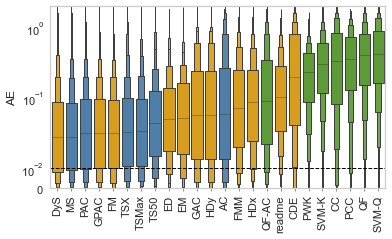

In [22]:
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = ae_df.groupby("alg").median().value.sort_values().index, 
                   data=ae_df)#, height=width/2, aspect=2)
ax.set_yscale('symlog', linthresh=0.01, linscale = 0.25)
ax.set(ylim=(0, 2), ylabel = "AE", xlabel=None)
plt.xticks(rotation=90)
plt.axhline(0.01, color = "black", linestyle = '--', lw = 1)
plt.grid(which='major', axis = 'y')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_AE_general")

Plot for NKLD Score:

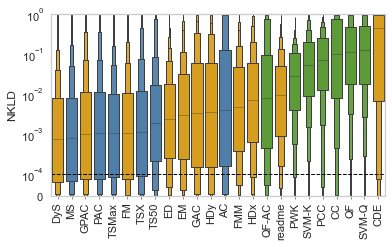

In [23]:
ax = sns.boxenplot(x="alg", y="value", showfliers=False,  
                   palette = cmap, 
                   order = nkld_df.groupby("alg").median().value.sort_values().index, 
                   data=nkld_df)#, height=width/2, aspect=2)
ax.set(ylim=(0, 1.02), ylabel = "NKLD", xlabel=None)
ax.set_yscale('symlog', linthresh=0.0001, linscale = 0.5)
ax.set_yticks([0,0.0001,0.001,0.01, 0.1,1])
plt.axhline(0.0001, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_NKLD_general")

### 1.2 Influence of Concept Drift

Plots for AE score:

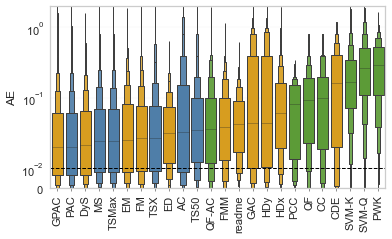

In [24]:
df_ae_lowshift = ae_df[ae_df["Drift_MAE"] < 0.2]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_ae_lowshift.groupby("alg").median().value.sort_values().index, 
                   data=df_ae_lowshift)
ax.set_yscale('symlog', linthresh=0.01, linscale = 0.25)
ax.set(ylim=(0, 2), ylabel = "AE", xlabel=None)
plt.axhline(0.01, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_AE_lowdrift")

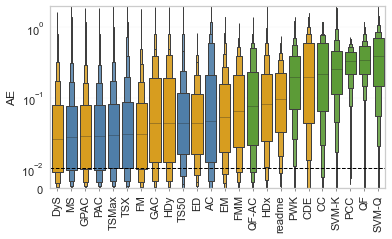

In [25]:
df_ae_medshift = ae_df[(ae_df["Drift_MAE"] >= 0.2 ) & (ae_df["Drift_MAE"] < 0.4)]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_ae_medshift.groupby("alg").median().value.sort_values().index, 
                   data=df_ae_medshift)
ax.set_yscale('symlog', linthresh=0.01, linscale = 0.25)
ax.set(ylim=(0, 2), ylabel = "AE", xlabel=None)
plt.axhline(0.01, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_AE_meddrift")

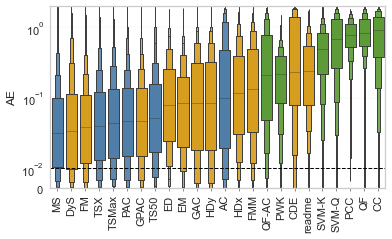

In [26]:
df_ae_highshift = ae_df[ae_df["Drift_MAE"] >= 0.4]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_ae_highshift.groupby("alg").median().value.sort_values().index, 
                   data=df_ae_highshift)

ax.set_yscale('symlog', linthresh=0.01, linscale = 0.25)
ax.set(ylim=(0, 2), ylabel = "AE", xlabel=None)
plt.axhline(0.01, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_AE_highdrift")

Plots for NKLD score:

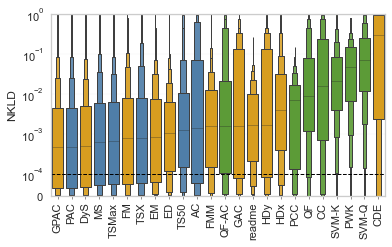

In [27]:
df_nkld_lowshift = nkld_df[nkld_df["Drift_MAE"] < 0.2]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_nkld_lowshift.groupby("alg").median().value.sort_values().index, 
                   data=df_nkld_lowshift)
ax.set(ylim=(0, 1.02), ylabel = "NKLD", xlabel=None)
ax.set_yscale('symlog', linthresh=0.0001, linscale = 0.5)
ax.set_yticks([0,0.0001,0.001,0.01, 0.1,1])
plt.axhline(0.0001, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_NKLD_lowdrift")

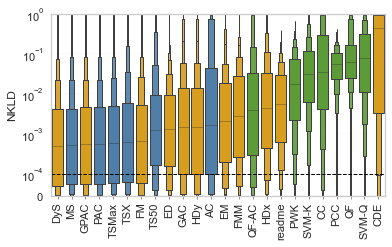

In [28]:
df_nkld_medshift = nkld_df[(nkld_df["Drift_MAE"] >= 0.2 ) & (nkld_df["Drift_MAE"] < 0.4)]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_nkld_medshift.groupby("alg").median().value.sort_values().index, 
                   data=df_nkld_medshift)
ax.set(ylim=(0, 1.02), ylabel = "NKLD", xlabel=None)
ax.set_yscale('symlog', linthresh=0.0001, linscale = 0.5)
ax.set_yticks([0,0.0001,0.001,0.01, 0.1,1])
plt.axhline(0.0001, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_NKLD_meddrift")

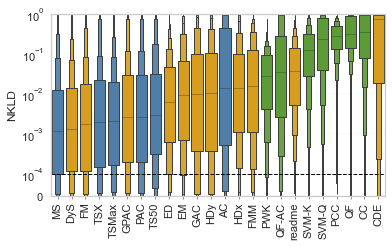

In [29]:
df_nkld_highshift = nkld_df[nkld_df["Drift_MAE"] >= 0.4]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_nkld_highshift.groupby("alg").median().value.sort_values().index, 
                   data=df_nkld_highshift)
ax.set(ylim=(0, 1.02), ylabel = "NKLD", xlabel=None)
ax.set_yscale('symlog', linthresh=0.0001, linscale = 0.5)
ax.set_yticks([0,0.0001,0.001,0.01, 0.1,1])
plt.axhline(0.0001, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_NKLD_highdrift")

### 1.3 Performance under Small Amounts of Training Data

Plot for AE score:

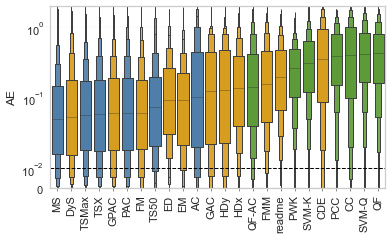

In [30]:
df_ae_fewtrain = ae_df[(ae_df["TT_split"] == "10/90")]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_ae_fewtrain.groupby("alg").median().value.sort_values().index, 
                   data=df_ae_fewtrain)
ax.set_yscale('symlog', linthresh=0.01, linscale = 0.25)
ax.set(ylim=(0, 2), ylabel = "AE", xlabel=None)
plt.axhline(0.01, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_AE_lowtrain")

Plot for NKLD score:

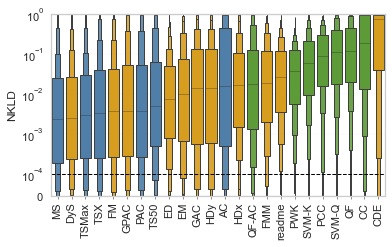

In [31]:
df_nkld_fewtrain = nkld_df[(nkld_df["TT_split"] == "10/90")]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_nkld_fewtrain.groupby("alg").median().value.sort_values().index, 
                   data=df_nkld_fewtrain)
ax.set(ylim=(0, 1.02), ylabel = "NKLD", xlabel=None)
ax.set_yscale('symlog', linthresh=0.0001, linscale = 0.5)
ax.set_yticks([0,0.0001,0.001,0.01, 0.1,1])
plt.axhline(0.0001, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_binary_NKLD_lowtrain")

## 2 Plots for Multiclass Quantification

### 2.1 General Results

Plot for AE score:

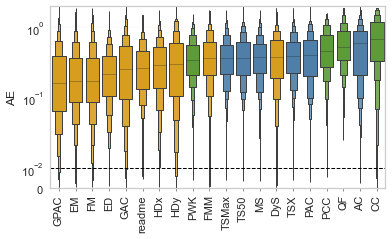

In [32]:
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = ae_mc_df.groupby("alg").median().value.sort_values().index, 
                   data=ae_mc_df)

ax.set_yscale('symlog', linthresh=0.01, linscale = 0.25)
ax.set(ylim=(0, 2), ylabel = "AE", xlabel=None)
plt.axhline(0.01, color = "black", linestyle = '--', lw = 1)
plt.yticks([0,.01,.1,1,2])
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_mc_AE_general")

Plot for NKLD score:

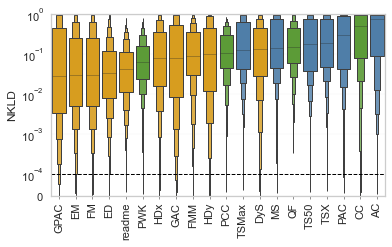

In [33]:
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = nkld_mc_df.groupby("alg").median().value.sort_values().index, 
                   data=nkld_mc_df)

ax.set(ylim=(0, 1.02), ylabel = "NKLD", xlabel=None)
ax.set_yscale('symlog', linthresh=0.0001, linscale = 0.5)
ax.set_yticks([0,0.0001,0.001,0.01, 0.1,1])
plt.axhline(0.0001, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_mc_NKLD_general")

### 2.2 Influence of Distribution Shift

Plots for AE score:

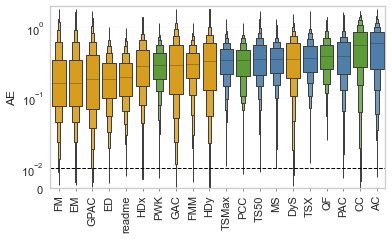

In [34]:
df_mc_ae_lowshift = ae_mc_df[ae_mc_df["Drift_MAE"] < 0.25]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_mc_ae_lowshift.groupby("alg").median().value.sort_values().index, 
                   data=df_mc_ae_lowshift)
ax.set_yscale('symlog', linthresh=0.01, linscale = 0.25)
ax.set(ylim=(0, 2), ylabel = "AE", xlabel=None)
plt.axhline(0.01, color = "black", linestyle = '--', lw = 1)
plt.yticks([0,.01,.1,1,2])
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_mc_AE_lowshift")

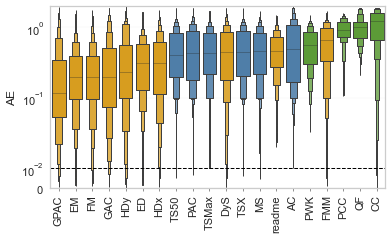

In [35]:
df_mc_ae_highshift = ae_mc_df[ae_mc_df["Drift_MAE"] >= 0.25]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_mc_ae_highshift.groupby("alg").median().value.sort_values().index, 
                   data=df_mc_ae_highshift)
ax.set_yscale('symlog', linthresh=0.01, linscale = 0.25)
ax.set(ylim=(0, 2), ylabel = "AE", xlabel=None)
plt.axhline(0.01, color = "black", linestyle = '--', lw = 1)
plt.yticks([0,.01,.1,1,2])
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_mc_AE_highshift")

Plots for NKLD score:

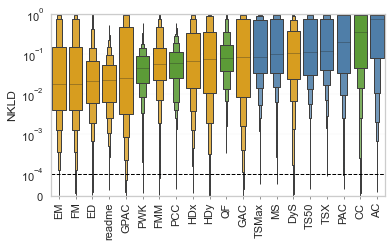

In [36]:
df_mc_nkld_lowshift = nkld_mc_df[nkld_mc_df["Drift_MAE"] < 0.25]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_mc_nkld_lowshift.groupby("alg").median().value.sort_values().index, 
                   data=df_mc_nkld_lowshift)
#ax.set_yscale('symlog', linthreshy=0.1)
ax.set(ylim=(0, 1.02), ylabel = "NKLD", xlabel=None)
ax.set_yscale('symlog', linthresh=0.0001, linscale = 0.5)
ax.set_yticks([0,0.0001,0.001,0.01, 0.1,1])
plt.axhline(0.0001, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_mc_NKLD_lowshift")

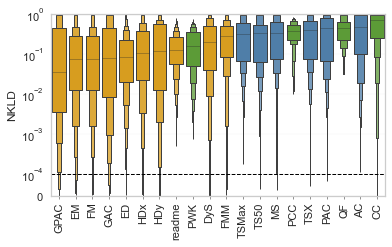

In [38]:
df_mc_nkld_highshift = nkld_mc_df[nkld_mc_df["Drift_MAE"] >= 0.25]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_mc_nkld_highshift.groupby("alg").median().value.sort_values().index, 
                   data=df_mc_nkld_highshift)

ax.set(ylim=(0, 1.02), ylabel = "NKLD", xlabel=None)
ax.set_yscale('symlog', linthresh=0.0001, linscale = 0.5)
ax.set_yticks([0,0.0001,0.001,0.01, 0.1,1])
plt.axhline(0.0001, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_mc_NKLD_highshift")

### 2.3 Performance under Small Amounts of Training Data

Plot for AE score:

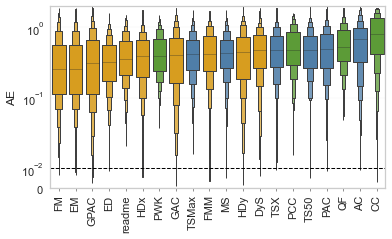

In [39]:
df_mc_ae_fewtrain = ae_mc_df[ae_mc_df["TT_split"] == "10/90"]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_mc_ae_fewtrain .groupby("alg").median().value.sort_values().index, 
                   data=df_mc_ae_fewtrain )
ax.set_yscale('symlog', linthresh=0.01, linscale = 0.25)
ax.set(ylim=(0, 2), ylabel = "AE", xlabel=None)
plt.axhline(0.01, color = "black", linestyle = '--', lw = 1)
plt.yticks([0,.01,.1,1,2])
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_mc_AE_fewtrain")

Plot for NKLD score:

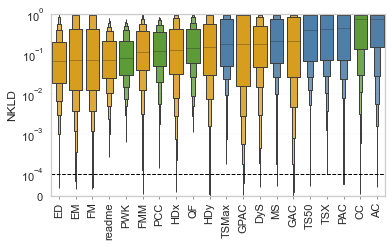

In [40]:
df_mc_nkld_fewtrain = nkld_mc_df[nkld_mc_df["TT_split"] == "10/90"]
ax = sns.boxenplot(x="alg", y="value", showfliers=False, 
                   palette = cmap, 
                   order = df_mc_nkld_fewtrain.groupby("alg").median().value.sort_values().index, 
                   data=df_mc_nkld_fewtrain)

ax.set(ylim=(0, 1.02), ylabel = "NKLD", xlabel=None)
ax.set_yscale('symlog', linthresh=0.0001, linscale = 0.5)
ax.set_yticks([0,0.0001,0.001,0.01, 0.1,1])
plt.axhline(0.0001, color = "black", linestyle = '--', lw = 1)
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(plot_path + "boxen_mc_NKLD_fewtrain")

## 3 CD Plots

CD Plots are created based on tables of average performances of each algoithms per dataset which have been generated via R scripts

In [41]:
## autorank package needed: 
from autorank import autorank, plot_stats, create_report, latex_table
from autorank._util import *

In [42]:
for f in os.listdir(table_path):
    if f.endswith(".csv"):
        df = pd.read_csv(table_path + f, index_col = 0)
        
        # need to hack into autorank to plot CDs for Multiclass, as by default, 
        # autorank would use other test than friedman-nemenyi
        if f.startswith("mc"):
            alpha = 0.05
            alpha_normality = alpha / len(df.columns)
            pval_homogeneity = stats.levene(*df.transpose().values).pvalue
            all_normal, pvals_shapiro = test_normality(df, alpha_normality, verbose=False)
            all_normal=False
            homogeneity_test = 'levene'
            var_equal = pval_homogeneity >= alpha
            res = rank_multiple_nonparametric(df, alpha=0.05, verbose=False, order="ascending", all_normal=False, effect_size=None)
            result = RankResult(res.rankdf, res.pvalue, res.cd, res.omnibus, res.posthoc, all_normal, pvals_shapiro,
                          var_equal, pval_homogeneity, homogeneity_test, alpha, alpha_normality, len(df), None, None,
                          None, None, res.effect_size)
            cd_diagram(result, False, None, width)
            fig = plt.gcf()
            fig.set_size_inches(width, height)
            plt.savefig(plot_path + "CD_" + f[:-4] + ".png")
            plt.close()
            
        else:
            result = autorank(-df, alpha=0.05, verbose=False)
            cd_diagram(result, False, None, width)
            fig = plt.gcf()
            fig.set_size_inches(width, height)
            plt.savefig(plot_path + "CD_" + f[:-4] + ".png")
            plt.close()